In [ ]:
# from numpy import load

# circuit1_npz = load('./Circuit1/spectrum-f_min_0-f_max_12501-f_step_250.npz')
# circuit2_npz = load('./Circuit2/spectrum-f_min_0-f_max_12501-f_step_250.npz')

# circuit1_npz_array = circuit1_npz['arr_0']
# circuit2_npz_array = circuit2_npz['arr_0']

# with open(f'circuit1_data.csv', 'w') as f:
#         f.write('Frequency,Z_real,Z_imag\n')
# with open(f'circuit2_data.csv', 'w') as f:
#         f.write('Frequency,Z_real,Z_imag\n')

# for i in range(0, len(circuit1_npz_array)):
#     frequency = i * 250
#     with open(f'circuit1_data.csv', 'a') as f:
#         real_part = circuit1_npz_array[i][0].real
#         imag_part = circuit1_npz_array[i][0].imag
#         f.write(f"{frequency},{real_part},{imag_part}\n")

#     with open(f'circuit2_data.csv', 'a') as f:
#         real_part = circuit2_npz_array[i][0].real
#         imag_part = circuit2_npz_array[i][0].imag
#         f.write(f"{frequency},{real_part},{imag_part}\n")

In [ ]:
import numpy as np
import random
import pandas as pd
import cProfile

def log_likelihood(Z_n, omega_n, R, C, sigma):
    """
    Calculates the likelihood of observing the measured impedance data given 
    a specific circuit model and its parameters.

    Args:
        Z_i (complex): Measured impedance at frequency omega_i.
        omega_i (float): Angular frequency.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Likelihood value.
    """
    
    # Calculate impedance from the circuit model
    z_omega_i = circuit_impedance(omega_n, R, C)
    log_likelihood_value = -(1 / (2 * sigma**2)) * abs(Z_n - z_omega_i)**2 - 0.5 * np.log(2 * np.pi * sigma**2)

    return log_likelihood_value  # Return the log-likelihood

def circuit_impedance(omega_n, R, C):
    """
    Calculates the impedance of the circuit model at given frequencies.

    Args:
        omega_n (list or numpy array): Angular frequencies.
        R (list): List of resistance values in the circuit model.
        C (list): List of capacitance values in the circuit model.

    Returns:
        numpy array: Impedances of the circuit model for each frequency.
    """
    
    omega_n = np.array(omega_n)  # Convert to NumPy array for vectorization
    R = np.array(R)
    C = np.array(C)
    z_omega_n = np.zeros_like(omega_n, dtype=complex)  # Initialize an array to store impedances

    for i in range(len(R)):
        z_omega_n += R[i] / (1 + 1j * omega_n * R[i] * C[i])  # Vectorized calculation

    return z_omega_n

def log_prior(R, C, R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Calculates the prior probability of the circuit parameters.

    Args:
        R (list): List of resistance values.
        C (list): List of capacitance values.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        float: Prior probability value.
    """
    
    for r in R:
        if not (R_min <= r <= R_max):
            return -np.inf  # Prior is 0 if resistance is outside the allowed range
    for c in C:
        if not (C_min <= c <= C_max):
            return -np.inf  # Prior is 0 if capacitance is outside the allowed range
    
    # If all parameters are within the allowed range, use uniform prior
    return 0  # Log of a uniform distribution is 0  

def log_posterior(omega_n, Z_n, K, R, C, sigma):
    """
    Calculates the posterior probability of the circuit parameters given the 
    observed data and the prior.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        R (list): List of resistance values.
        C (list): List of capacitance values.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: Posterior probability value.
    """   
    log_prior_prob = log_prior(R, C)
    if log_prior_prob == -np.inf:
        return -np.inf  # If log-prior is -inf, log-posterior is also -inf

    log_likelihood_prob = 0
    
    log_likelihood_prob += np.sum(log_likelihood(Z_n, omega_n, R, C, sigma))

    log_posterior_prob = log_likelihood_prob + log_prior_prob
    return log_posterior_prob  # Return the un-logged posterior probability


def metropolis(omega_n, Z_n, K, sigma, n_iterations=10000, burn_in=1000, 
              R_min=100, R_max=10e3, C_min=10e-9, C_max=10e-6):
    """
    Performs Metropolis sampling to estimate the circuit parameters.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        sigma (float): Standard deviation of the measurement noise.
        n_iterations (int, optional): Number of MCMC iterations. Defaults to 10000.
        burn_in (int, optional): Number of initial samples to discard. Defaults to 1000.
        R_min (float, optional): Minimum resistance value. Defaults to 100.
        R_max (float, optional): Maximum resistance value. Defaults to 10e3.
        C_min (float, optional): Minimum capacitance value. Defaults to 10e-9.
        C_max (float, optional): Maximum capacitance value. Defaults to 10e-6.

    Returns:
        tuple: A tuple containing the accepted R and C samples.
    """

    # Initialize parameters
    R_current = [random.uniform(R_min, R_max) for _ in range(K)]
    C_current = [random.uniform(C_min, C_max) for _ in range(K)]
    accepted_proposals = 0
    # Store accepted samples
    R_samples = []
    C_samples = []
    
    for _ in range(n_iterations):
        # Propose new parameters
        R_proposal = [r + random.uniform(-10, 10) for r in R_current]
        C_proposal = [c + random.uniform(-10e-9, 10e-9) for c in C_current]  # REPORT: change it normal distribution and compare.

        # Calculate posterior probabilities
        log_posterior_current = log_posterior(omega_n, Z_n, K, R_current, C_current, sigma)
        log_posterior_proposal = log_posterior(omega_n, Z_n, K, R_proposal, C_proposal, sigma)

        # Calculate log of acceptance ratio
        log_acceptance_ratio = log_posterior_proposal - log_posterior_current
        acceptance_ratio = min(1, log_acceptance_ratio)  # 0 if log_acceptance_ratio is positive, else log_acceptance_ratio
        
        # Accept or reject proposal (using exp(acceptance_ratio) since acceptance_ratio is in log space)
        if np.log(random.uniform(0, 1)) < acceptance_ratio:
            R_current = R_proposal
            C_current = C_proposal
            accepted_proposals += 1
        # Store accepted samples after burn-in
        if _ > burn_in:
            R_samples.append(R_current)
            C_samples.append(C_current)

    return R_current, C_current, accepted_proposals, R_samples, C_samples

def wbic(omega_n, Z_n, K, R_samples, C_samples, sigma):
    """
    Calculates the Widely Applicable Bayesian Information Criterion (WBIC) 
    for a given circuit model and its parameters.

    Args:
        omega_n (list): List of angular frequencies.
        Z_n (list): List of measured impedances.
        K (int): Number of RC parallel circuits in the model.
        R_samples (list): List of accepted resistance samples from MCMC.
        C_samples (list): List of accepted capacitance samples from MCMC.
        sigma (float): Standard deviation of the measurement noise.

    Returns:
        float: WBIC value.
    """
    
    n = len(omega_n)
    beta = 1 / np.log(n)
    log_likelihood_sum = 0

    R_samples = np.array(R_samples)
    C_samples = np.array(C_samples)

    for i in range(n):
        Z_i = Z_n[i]  # Get the current Z_i
        omega_i = omega_n[i]  # Get the current omega_i

        # Vectorized calculation of impedance for all samples at once
        z_omega_i = np.sum(R_samples / (1 + 1j * omega_i * R_samples * C_samples), axis=1)  

        # Vectorized calculation of log-likelihood for all samples at once
        log_likelihood_sum += np.sum(-(1 / (2 * sigma**2)) * np.abs(Z_i - z_omega_i)**2 - np.log(np.sqrt(2 * np.pi * sigma**2)))

    wbic_value = - beta * log_likelihood_sum 
    return wbic_value


## Support functions

In [22]:
import matplotlib.pyplot as plt

def find_best_fit_model(frequencies, Z_measured, sigma = 10, K_max=2, n_itterations=10000, burn_in=1000):
    wbic_values = []
    for k in range(1, K_max + 1):  # Check models with K=1, 2
        R_n, C_n, accepted_proposals, R_samples, C_samples = metropolis(frequencies, Z_measured, k, sigma, n_iterations=n_itterations, burn_in=burn_in)
        wbic_value = wbic(frequencies, Z_measured, k, R_samples, C_samples, sigma)
        wbic_values.append(wbic_value)
        
    # Select the best model
    best_model = np.argmin(wbic_values) + 1  # +1 because K starts from 1
    return best_model, wbic_values

def single_mcmc(data_filename, K, sigma=10, itterations=10000, burn_in=1000, print_results=False):
    data = pd.read_csv(data_filename)
    frequency_list = data['Frequency']  # Hz
    Z_complex = np.array(data['Z_real']) + 1j * np.array( data['Z_imag'])

    R_samples = []
    C_samples = []
    R_n, C_n, accepted_proposals, R_samples, C_samples = metropolis(frequency_list, Z_complex, K, sigma, n_iterations=itterations, burn_in=burn_in)
    acceptance_rate = accepted_proposals / itterations * 100
    if print_results:
        print(f"Acceptance rate: {acceptance_rate:.2f}%")
        if len(R_n) == 1:
            print(f"Estimated R value: {np.mean(R_n[0]):.2f}")
            print(f"Estimated C value: {np.mean(C_n[0]):.2e}")
        else:
            print(f"Estimated R value: {np.mean(R_n[0]):.2f}\t{np.mean(R_n[1]):.2f}")
            print(f"Estimated C value: {np.mean(C_n[0]):.2e}\t{np.mean(C_n[1]):.2e}")
        print('')

    results = {
        'R_n': R_n,
        'C_n': C_n,
        'R_samples': R_samples,
        'C_samples': C_samples,
        'acceptance_rate': acceptance_rate,
        'frequency_list': frequency_list,
        'Z_complex': Z_complex
    }
    return results

def impedance_plot(frequencies, Z_measured, R, C, ax=None): 
    if ax is None:
        ax = plt.gca()  # Get the current axes if none is provided

    Z_model = [circuit_impedance(omega, R, C) for omega in frequencies]

    ax.plot(frequencies, np.real(Z_model), label='Calculated Z_real')
    ax.plot(frequencies, np.imag(Z_model), label='Calculated Z_imag')
    ax.plot(frequencies, np.real(Z_measured), 'o', label='Measured Z_real')
    ax.plot(frequencies, np.imag(Z_measured), 'o', label='Measured Z_imag')
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Impedance')
    ax.set_title('Impedance vs Frequency')
    ax.legend()
    ax.grid()

def R_C_plot(R_samples, C_samples, ax=None):
    if ax is None:
        ax = plt.gca()  # Get the current axes if none is provided

    ax.plot(R_samples)
    ax.set_title('R_n values')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Resistance (Ohms)')

def R_C_plot(R_samples, C_samples, ax_r, ax_c):
    if ax_r is None:
        return
    if ax_c is None:
        return
    ax_r.plot(R_samples, label='Resistance (Ohms)')
    ax_r.set_title('R_n values')
    ax_r.set_xlabel('Iteration')
    ax_r.set_ylabel('Value')
    ax_r.legend()

    ax_c.plot(C_samples, label='Capacitance (Farads)')    
    ax_c.set_title('C_n values')
    ax_c.set_xlabel('Iteration')
    ax_c.set_ylabel('Value')
    ax_c.legend()

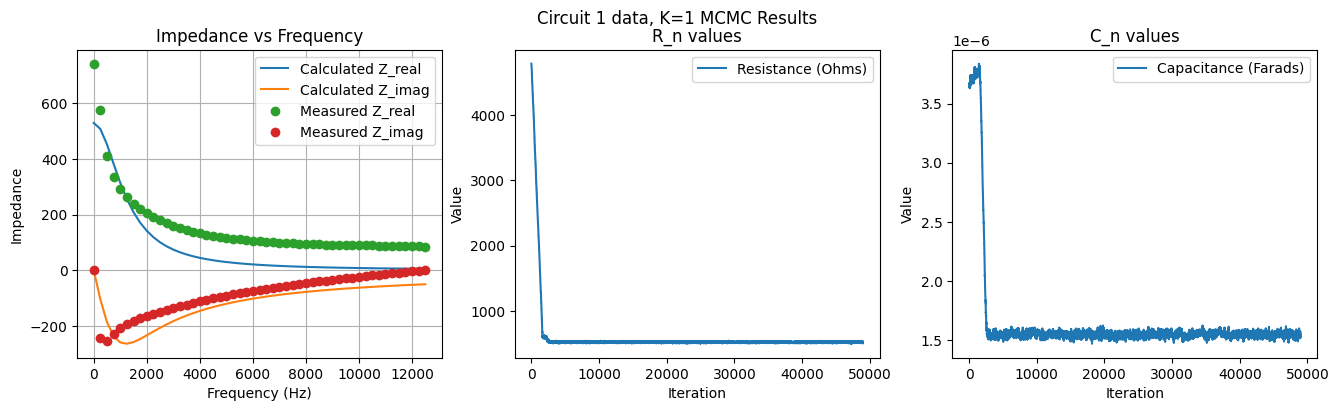

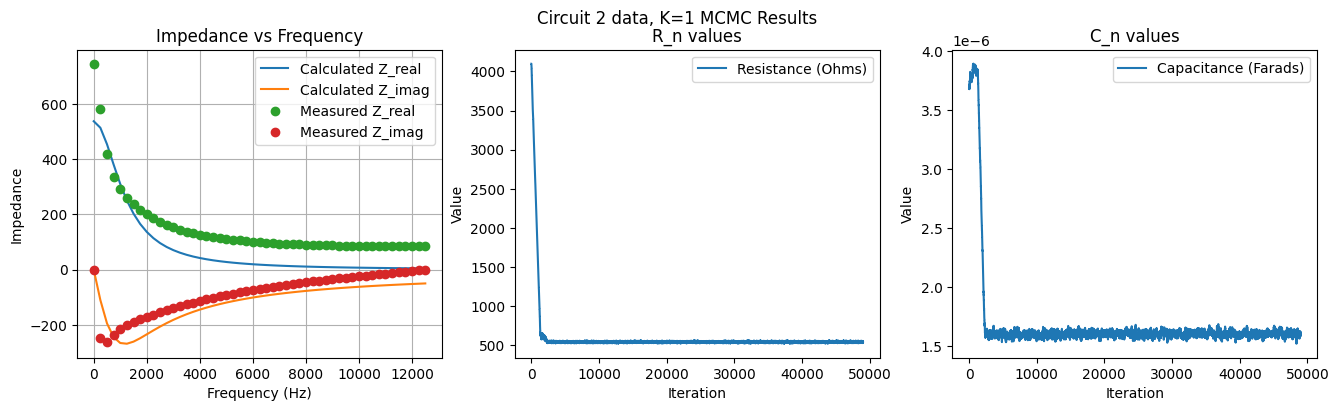

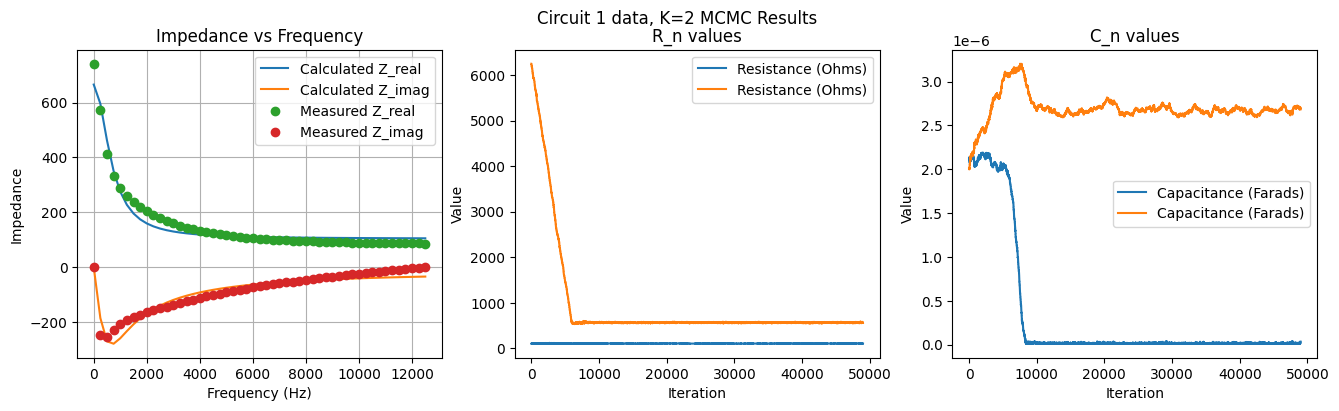

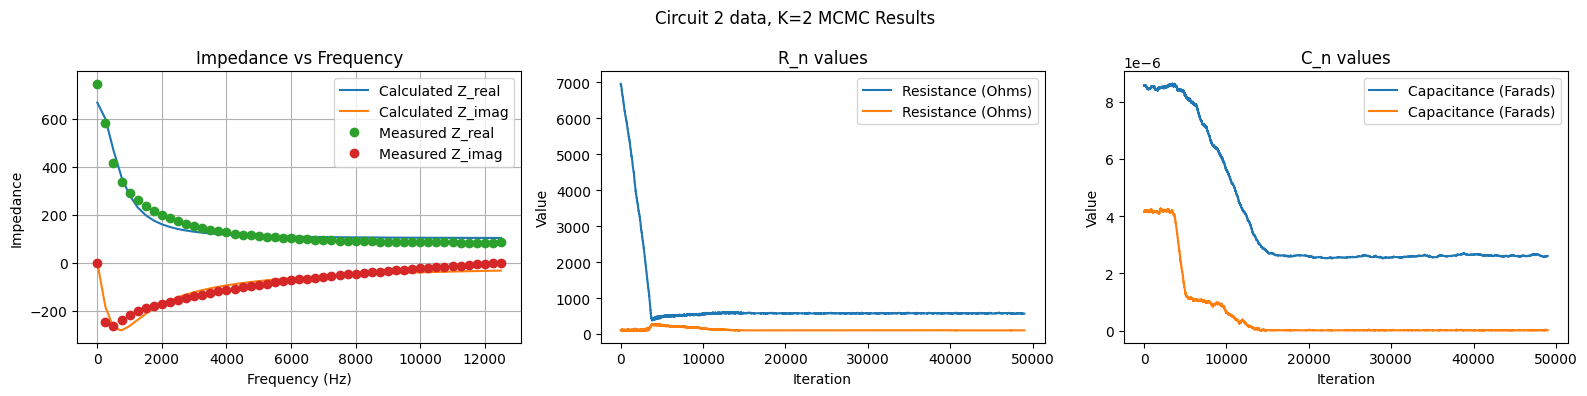

In [26]:
results = single_mcmc('circuit1_data.csv', 1, itterations = 20000)
fig_c1_k1, (ax_c1_k1_1, ax_c1_k1_2, ax_c1_k1_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c1_k1.suptitle('Circuit 1 data, K=1 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c1_k1_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c1_k1_2, ax_c=ax_c1_k1_3)  

results = single_mcmc('circuit2_data.csv', 1, itterations = 50000)
fig_c2_k1, (ax_c2_k1_1, ax_c2_k1_2, ax_c2_k1_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c2_k1.suptitle('Circuit 2 data, K=1 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c2_k1_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c2_k1_2, ax_c=ax_c2_k1_3)  

results = single_mcmc('circuit1_data.csv', 2, itterations = 50000)
fig_c1_k2, (ax_c1_k2_1, ax_c1_k2_2, ax_c1_k2_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c1_k2.suptitle('Circuit 1 data, K=2 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c1_k2_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c1_k2_2, ax_c=ax_c1_k2_3)  

results = single_mcmc('circuit2_data.csv', 2, itterations = 50000)
fig_c2_k1, (ax_c2_k2_1, ax_c2_k2_2, ax_c2_k2_3) = plt.subplots(1, 3, figsize=(16, 4))
fig_c2_k1.suptitle('Circuit 2 data, K=2 MCMC Results')
impedance_plot(results['frequency_list'], results['Z_complex'], results['R_n'], results['C_n'], ax=ax_c2_k2_1) 
R_C_plot(results['R_samples'], results['C_samples'], ax_r=ax_c2_k2_2, ax_c=ax_c2_k2_3)  


plt.tight_layout()
plt.show()

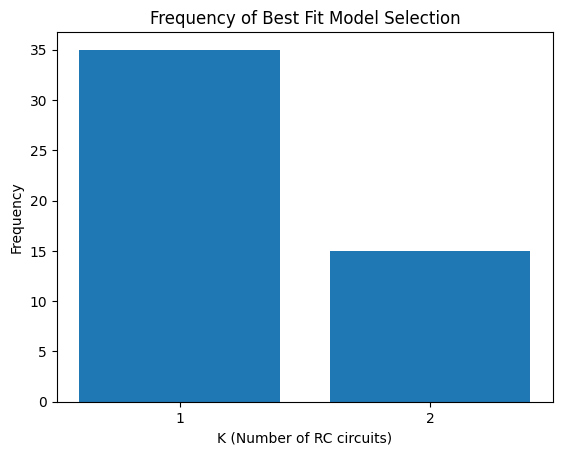

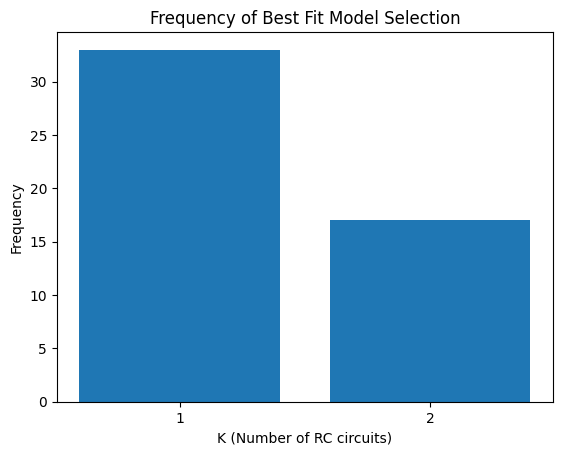

In [27]:
c1_data = pd.read_csv("circuit1_data.csv")
c1_frequencies = c1_data['Frequency']  # Hz
c1_Z_measured = np.array(c1_data['Z_real']) + 1j * np.array(c1_data['Z_imag'])
K_max = 2
K_n = np.zeros(K_max)

for i in range(50):
    best_model, wbic_values = find_best_fit_model(c1_frequencies, c1_Z_measured, sigma=10, n_itterations=50_000, K_max=K_max, burn_in=1000)
    K_n[best_model - 1] += 1 

# Plotting the bar chart of K_n
plt.bar(range(1, K_max + 1), K_n)
plt.xlabel('K (Number of RC circuits)')
plt.ylabel('Frequency')
plt.title('Frequency of Best Fit Model Selection')
plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis
plt.show()

c2_data = pd.read_csv("circuit1_data.csv")
c2_frequencies = c1_data['Frequency']  # Hz
c2_Z_measured = np.array(c2_data['Z_real']) + 1j * np.array(c2_data['Z_imag'])
K_n = np.zeros(K_max)

for i in range(50):
    best_model, wbic_values = find_best_fit_model(c2_frequencies, c2_Z_measured, sigma=10, n_itterations= 50_000, K_max=K_max, burn_in=1000)
    K_n[best_model - 1] += 1 

# Plotting the bar chart of K_n
plt.bar(range(1, K_max + 1), K_n)
plt.xlabel('K (Number of RC circuits)')
plt.ylabel('Frequency')
plt.title('Frequency of Best Fit Model Selection')
plt.xticks(range(1, K_max + 1))  # Ensure only integer values are shown on x-axis
plt.show()

In [25]:
# # Define function for Nyquist plots
# def plot_nyquist(ax, real, imag, color1, color2, color3, title):
#     complex_values = real + 1j * imag
#     ax.plot(complex_values.real, complex_values.imag, color=color1, label='Nyquist Path')
#     ax.plot(complex_values.real, -complex_values.imag, color=color2, linestyle='--', label='Mirror Path')
#     ax.scatter(complex_values.real, complex_values.imag, color=color3, label='Points')
#     ax.set_xlabel('Real Part')
#     ax.set_ylabel('Imaginary Part')
#     ax.set_title(title)
#     ax.legend()


# # Create subplots
# fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# # Plot for each subplot
# plot_nyquist(axs[0], real_circuit1, imag_circuit1, "blue", "green", "aqua", "Nyquist Plot: Circuit 1")
# plot_nyquist(axs[0], real_circuit2, imag_circuit2, "orange", "red", "yellow", "Nyquist Plot: Circuit 2")
# axs[0].set_title('Nyquist Plot: Circuit 1 and 2')

# plot_nyquist(axs[1], real_circuit1, imag_circuit1, "blue", "green", "aqua", "Nyquist Plot: Circuit 1")
# plot_nyquist(axs[2], real_circuit2, imag_circuit2, "orange", "red", "yellow", "Nyquist Plot: Circuit 2")

# # Add global grid and axis lines
# for ax in axs:
#     ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
#     ax.axvline(0, color='black', linewidth=0.8, linestyle='--')
#     ax.grid()

# plt.tight_layout()
# plt.show()